
# 项目：历届奥运会分析报告

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
<li><a href="#limitation">限制</a></li>
</ul>

<a id='intro'></a>
## 简介
此数据集中包含了从1896年雅典奥运会到2016年里约奥运会的部分数据。以下是此数据集的行列情况：

数据1：athlete_events.csv
1. ID - 表示每名运动员。
2. Name（姓名） - 运动员姓名
3. Sex（性别） - M（男） 或 F（女）
4. Age（年龄） - 整数型
5. Height（身高） - 单位：厘米
6. Weight（体重）- 单位：公斤
7. Team （国家）- 国家
8. NOC - 国家奥组委简写
9. Games（奥运会） - 参加的奥运会
10. Year（年份） - 整数型
11. Season（季节） - Summer（夏季） or Winter（冬季）
12. City （主办城市）- Host city（主办城市）
13. Sport（运动项目） - Sport（运动项目）
14. Event （具体运动名称）- Event（具体运动名称）
15. Medal （奖牌）- Gold（金牌）, Silver（银牌）, Bronze（铜牌）, or NA（空值）

数据2：noc_regions.csv
1. NOC - 国家奥组委简写
2. Region - 地区
3. Note - 备注

此数据集来自于 www.sports-reference.com 

除此之外，我们还将引入各国GDP数据和各国人口数据以探索经济和人口对于体育成绩的影响。

各国人口数据：WorldPopulation.csv

各国GDP数据：w_gdp.xls

### 注意事项
在1992年之前，冬季奥运会和夏季奥运会都是在同一年举办。在1992年之后，冬季奥运会和夏季奥运会分开举办。冬季奥运会从1994年开始每四年举办一次，夏季奥运会从1996年开始每四年举办一次。

<a id="wrangling"></a>
## 一、数据整理

In [6]:
#导入数据分析时需要的函数库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
#载入数据集
olympic_df = pd.read_csv('athlete_events.csv')
region_df = pd.read_csv('noc_regions.csv')

In [8]:
olympic_df.head(2)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN


In [9]:
olympic_df.shape

(271116, 15)

In [10]:
#查看缺失值
olympic_df.isnull().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

我们可以看到年龄、身高、体重和奖牌情况都有不同程度的缺失，前三项可能是数据丢失，大量的奖牌空值应该是没有奖牌，我们用 DNW (Did not win)来填充奖牌的缺失值。

In [11]:
#填补奖牌缺失值
olympic_df.Medal.fillna('DNW',inplace=True)

In [12]:
#确认修改
olympic_df.Medal.isnull().sum()

0

In [13]:
#查看重复行
olympic_df.duplicated().sum()

1385

In [14]:
#重复行在此数据集中无意义，删除重复行
olympic_df.drop_duplicates(inplace=True)

In [15]:
#查看每行的唯一值
olympic_df.nunique()

ID        135571
Name      134732
Sex            2
Age           74
Height        95
Weight       220
Team        1184
NOC          230
Games         51
Year          35
Season         2
City          42
Sport         66
Event        765
Medal          4
dtype: int64

我们从上面知道数据一共有26万行，而这里ID 和 Name 列都只有13万行数据，说明有大部分运动员参加多次奥运会，且运动员之间有重名情况，这在数十万名运动员里十分正常。同时引起我们注意的数据有NOC和Team列，我们从数据切片上来看 Team 列中显示的是国家，但是 Team 的唯一值总数高达1184，说明并不代表国家，NOC 的数目略微多与国家数。

In [16]:
#检查第二个数据集
region_df.head(2)

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles


In [17]:
region_df.nunique()

NOC       230
region    206
notes      21
dtype: int64

In [18]:
region_df.shape

(230, 3)

In [19]:
region_df.duplicated().sum()

0

In [20]:
region_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
NOC       230 non-null object
region    227 non-null object
notes     21 non-null object
dtypes: object(3)
memory usage: 5.5+ KB


region 数据集中的NOC数量和 olympic 数据集中的数量一致，region数和实际情况相同，说明有一个地区对应多喝奥委会的情况。

In [21]:
set(region_df.NOC.unique()) - set(olympic_df.NOC.unique())

{'SIN'}

In [22]:
set(olympic_df.NOC.unique()) - set(region_df.NOC.unique())

{'SGP'}

通过我们分析可以发现：region中NOC列数量虽然和olympic中NOC数量一致，但是有一出不同，region中有一国家缩写为SIN，olympic中有个国家缩写为SGP，我们猜测是统一国家只是缩写不同。

In [23]:
region_df.query('NOC == "SIN"')

,NOC,region,notes
178,SIN,Singapore,NaN


In [24]:
olympic_df.query('NOC == "SGP"').head(1)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
578,332,Zarinah Abdullah,F,21.0,NaN,NaN,Singapore,SGP,1992 Summer,1992,Summer,Barcelona,Badminton,Badminton Women's Singles,DNW


通过我们分析，两列值不同的原因确实是同一个国家（新加坡）的缩写不同

In [25]:
#合并数据集
olympic_df = olympic_df.merge(region_df,how = 'left',on='NOC')

olympic_df.head(1)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,NaN


In [26]:
#删除掉notes，改region列名以和其他列名保持一致
olympic_df.drop('notes',axis=1,inplace=True)

In [27]:
olympic_df.head(1)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China


In [28]:
olympic_df.rename(columns={'region':'Country'},inplace=True)
olympic_df.head(1)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China


因为我们打算用Country列取代Team列，所以我们要保证Country列的完整。

In [29]:
olympic_df.loc[olympic_df.Country.isnull(),['Team','NOC']].drop_duplicates()

,Team,NOC
578,Singapore,SGP
6259,Refugee Olympic Athletes,ROT
44161,June Climene,SGP
60733,Unknown,UNK
64317,Tuvalu,TUV
80536,Rika II,SGP
107955,Singapore-2,SGP
234682,Singapore-1,SGP


In [30]:
#检查为什么没有匹配成功
region_df.query('NOC == "ROT" or NOC == "UNK" or NOC == "TUV"')

,NOC,region,notes
168,ROT,NaN,Refugee Olympic Team
208,TUV,NaN,Tuvalu
213,UNK,NaN,Unknown


In [31]:
#将 Country 列中的空值替换掉
olympic_df['Country'] = np.where(olympic_df['NOC'] == 'SGP','Singapore',olympic_df['Country'])
olympic_df['Country'] = np.where(olympic_df['NOC'] == 'ROT','Refugee Olympic Team',olympic_df['Country'])
olympic_df['Country'] = np.where(olympic_df['NOC'] == 'TUK','Tuvalu',olympic_df['Country'])
olympic_df['Country'] = np.where(olympic_df['NOC'] == 'UNK','Unknow',olympic_df['Country'])

#删除Team列
olympic_df.drop('Team',axis=1,inplace=True)

olympic_df.head(1)

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China


<a id="eda"></a>
## 二、探索性数据分析

### 问题一：哪些城市多次举办过奥运会？分别举办的是哪几次？

In [32]:
city_games_df = pd.concat([olympic_df.Games,olympic_df.City],axis=1)

#删除重复项
city_games_df.drop_duplicates(inplace = True)

city_games_df['Games'].groupby(city_games_df.City).sum()

City
Albertville                                     1992 Winter
Amsterdam                                       1928 Summer
Antwerpen                                       1920 Summer
Athina                    2004 Summer1906 Summer1896 Summer
Atlanta                                         1996 Summer
Barcelona                                       1992 Summer
Beijing                                         2008 Summer
Berlin                                          1936 Summer
Calgary                                         1988 Winter
Chamonix                                        1924 Winter
Cortina d'Ampezzo                               1956 Winter
Garmisch-Partenkirchen                          1936 Winter
Grenoble                                        1968 Winter
Helsinki                                        1952 Summer
Innsbruck                            1964 Winter1976 Winter
Lake Placid                          1980 Winter1932 Winter
Lillehammer                        

In [33]:
city_games_df.City.count()

52

**结论：一共有52个城市举办过奥运会，其中不免有些城市多次举办。因斯布鲁克举办过1964年冬季奥运会和1976年冬季奥运会；纽约普莱西德湖举办过1932年冬季奥运会和1984年冬季奥运会；洛杉矶举办过1932年夏季奥运会和1984年夏季奥运会；巴黎举办过1900年夏季奥运会和1924年夏季奥运会；瑞士恩加丁山谷圣莫里茨举办过1928年冬季奥运会和1948年冬季奥运会；斯德哥尔摩举办过1912年夏季奥运会和1956年夏季奥运会；伦敦举办过1908年夏季奥运会，1948年夏季奥运会，2012年夏季奥运会；雅典举办过1896年夏季奥运会，1906年夏季奥运会，2004年夏季奥运会。**

## 问题二：金牌得主的年龄分布？

In [34]:
olympic_df.head(1)

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China


In [35]:
age_medal_df = olympic_df.query('Medal == "Gold"')

age_medal_df.head(2)

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark
42,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Team All-Around,Gold,Finland


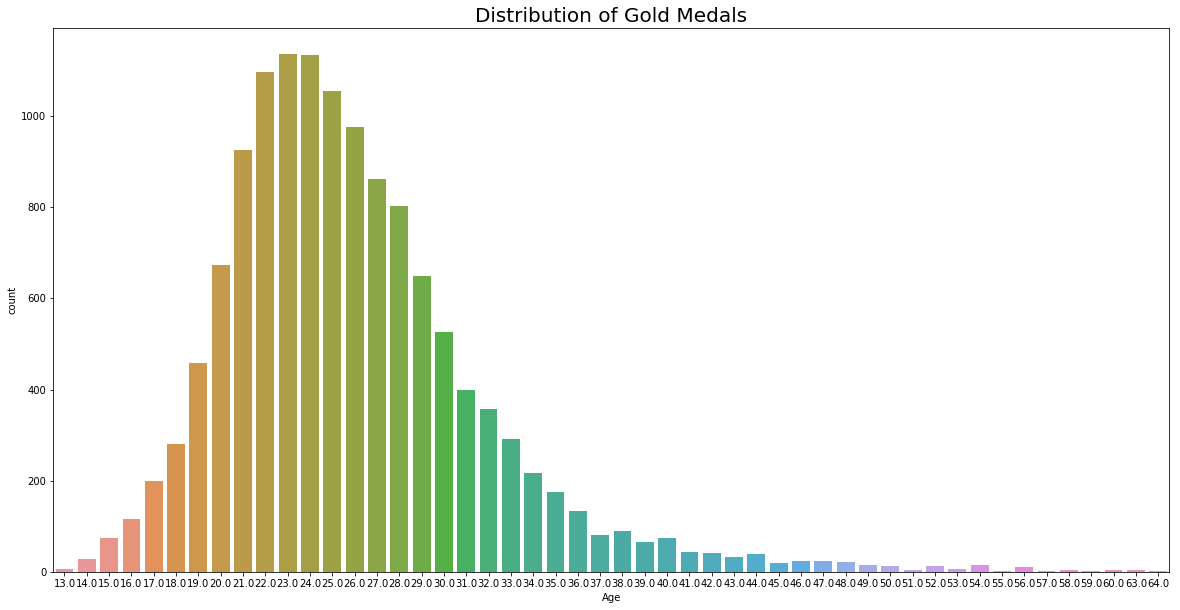

In [36]:
plt.figure(figsize=(20,10))
plt.tight_layout()
sns.countplot(age_medal_df['Age'])
plt.title('Distribution of Gold Medals',fontsize=20)
plt.show()

**结论：从图上我们可以看到，运动员的黄金年龄大致是21-28岁，23，24岁时运动员的巅峰时期。在历届奥运会中，获得金牌的年龄最小的运动员有13岁，年龄最大的到64岁，可以说是不输当年了。**

**我们注意到竟然有超过五十岁的金牌得主，我们具体来看一下这些人在哪些体育项目中摘金。**

In [37]:
age_50_df = age_medal_df['Sport'][age_medal_df['Age'] > 50]

age_50_df.head(2)

5072    Equestrianism
7949          Sailing
Name: Sport, dtype: object

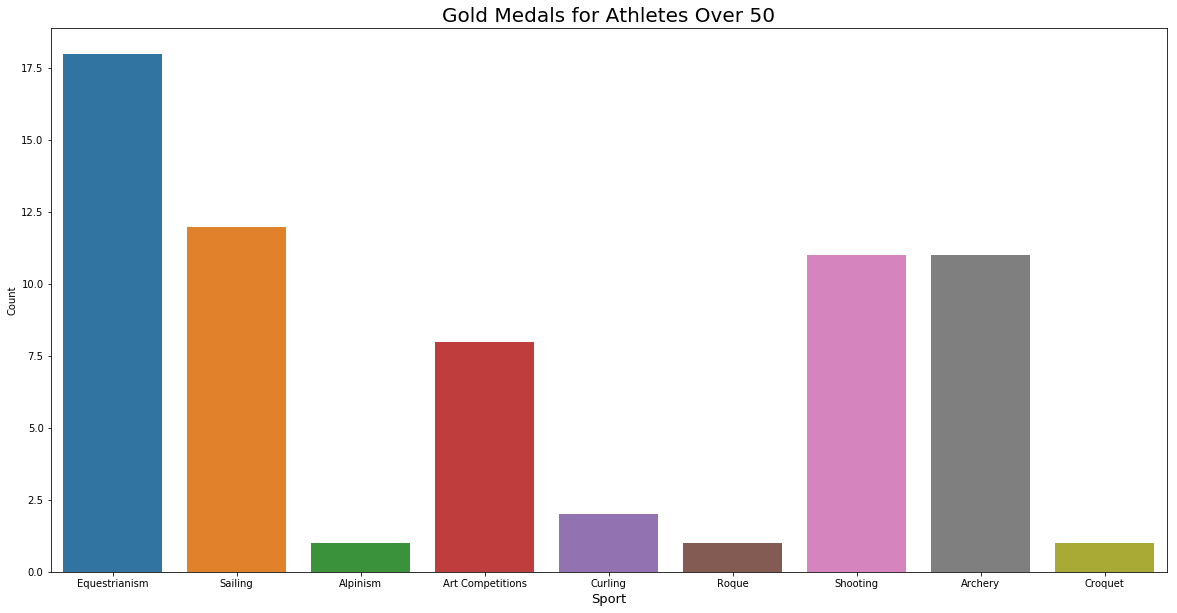

In [38]:
plt.figure(figsize=(20,10))
plt.tight_layout()
sns.countplot(age_50_df)
plt.title('Gold Medals for Athletes Over 50',fontsize=20)
plt.xlabel('Sport',fontsize=13)
plt.ylabel('Count')
plt.show();

In [39]:
age_50_df.value_counts()

Equestrianism       18
Sailing             12
Shooting            11
Archery             11
Art Competitions     8
Curling              2
Croquet              1
Roque                1
Alpinism             1
Name: Sport, dtype: int64

年过50参加奥运会并且能够获得金牌的得主中，其摘金项目以马术最为之多，其次还有射击射箭，艺术比赛等。

## 问题三：历届奥运会金牌榜情况

In [45]:
medal_top_10_df = olympic_df.query('Medal == "Gold"')['Country'].value_counts().reset_index(name='Medal').head(10)

medal_top_10_df

,index,Medal
0,USA,2638
1,Russia,1599
2,Germany,1301
3,UK,677
4,Italy,575
5,France,499
6,Sweden,479
7,Canada,463
8,Hungary,432
9,Norway,378


<Figure size 432x288 with 0 Axes>

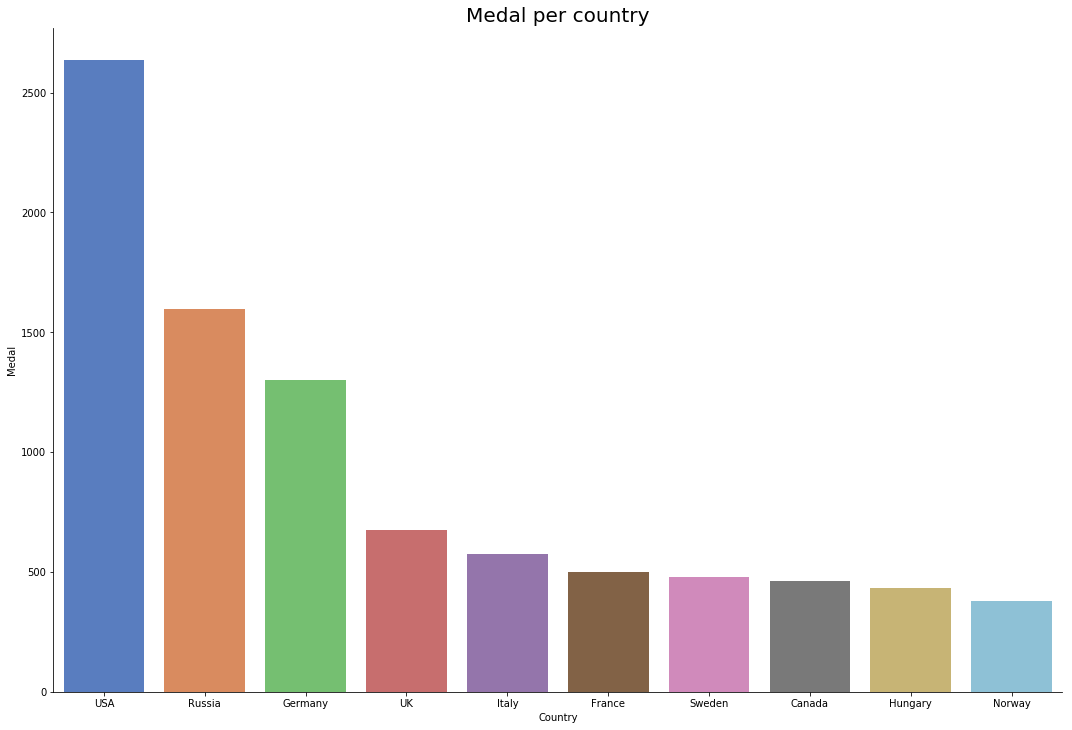

In [71]:
plt.figure()
plt.tight_layout()
f3 = sns.catplot(x='index',y='Medal',data=medal_top_10_df,kind='bar',height=10,aspect=1.5,palette='muted')

f3.set_xlabels('Country')
f3.set_ylabels('Medal')
plt.title('Medal per country',fontsize=20);

从图表上来看，美国、俄罗斯和德国遥遥领先，其中美国一枝独秀，一共获得过2638枚金牌。

## 问题四：历年奥运会参加人数变化（男/女）

In [72]:
olympic_df.head(1)

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China


In [100]:
male_olympic_df = olympic_df.query('Sex == "M" and Season == "Summer"')
female_olympic_df = olympic_df.query('Sex == "F" and Season == "Summer"')

In [101]:
male_count_df = male_olympic_df['ID'].groupby(by=male_olympic_df.Year).count().reset_index(name='Count')
male_count_df.head()

,Year,Count
0,1896,380
1,1900,1865
2,1904,1285
3,1906,1722
4,1908,3022


In [102]:
female_count_df = female_olympic_df['ID'].groupby(by=female_olympic_df.Year).count().reset_index(name='Count')

female_count_df.head()

,Year,Count
0,1900,33
1,1904,16
2,1906,11
3,1908,47
4,1912,87


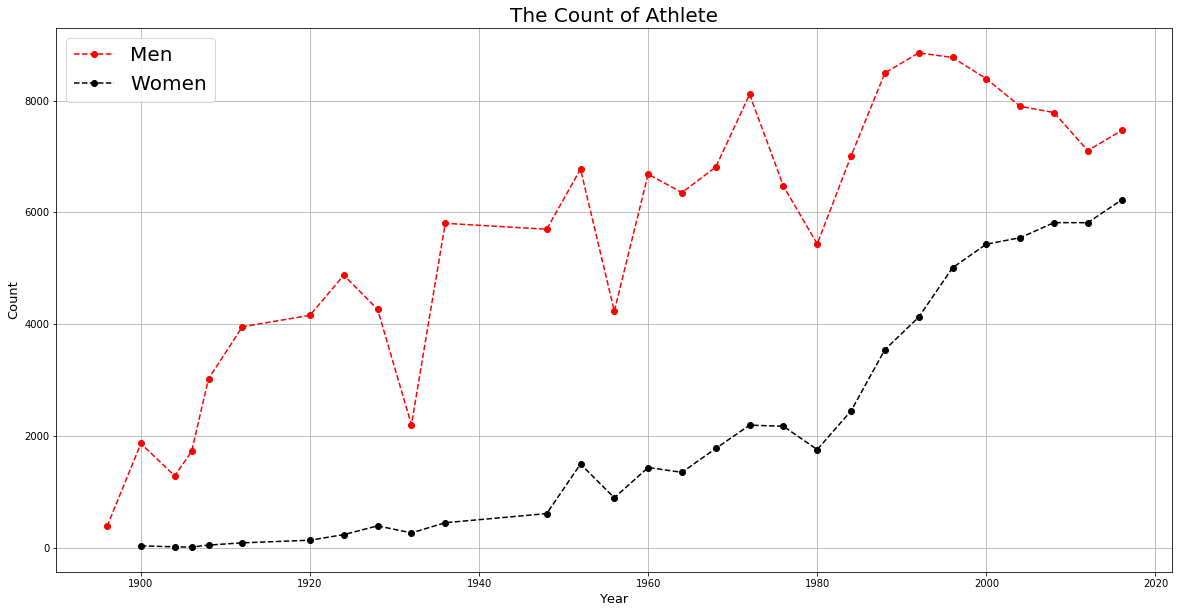

In [124]:
plt.figure(figsize=(20,10))
x1 = list(male_count_df['Year'])
y1 = list(male_count_df['Count'])
x2 = list(female_count_df['Year'])
y2 = list(female_count_df['Count'])
plt.plot(x1,y1,'ko--',c='r',label="Men")
plt.plot(x2,y2,'ko--',label="Women")
plt.legend(fontsize=20)
plt.grid()
plt.xlabel('Year',fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.title('The Count of Athlete',fontsize=20);

**参加奥运会的女子数目一直以来少于男子，不过就40年来，女子运动员数量激增，在2016年伦敦奥运会上男女运动员数目相差不大。**

## 问题五：运动员年龄有什么变化？

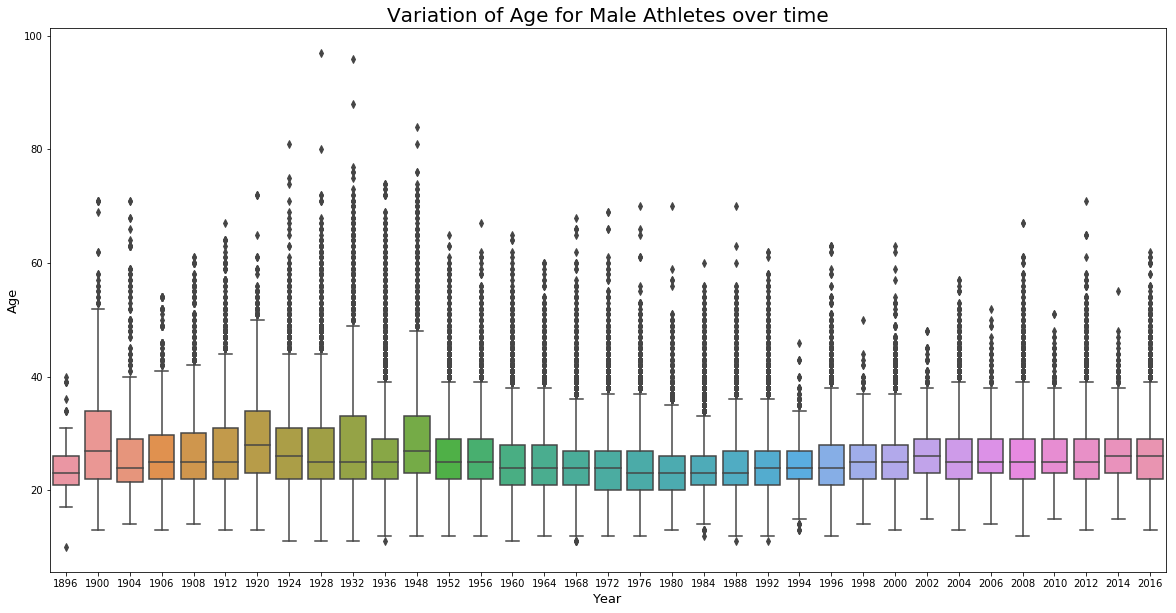

In [128]:
plt.figure(figsize=(20,10))
sns.boxplot(x='Year',y='Age',data=olympic_df)
plt.xlabel('Year',fontsize=13)
plt.ylabel('Age',fontsize=13)
plt.title('Variation of Age for Male Athletes over time',fontsize=20);

**运动员年龄历年来相差不大，大致都在25岁左右。在1924年-1948年，有很多年龄超过八十的运动员，我们下面来了解一下。**

In [129]:
age_over_80 = olympic_df.query('Age > 80')

age_over_80

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
9355,5146,George Denholm Armour,M,84.0,NaN,NaN,GBR,1948 Summer,1948,Summer,London,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",DNW,UK
60519,31173,Thomas Cowperthwait Eakins,M,88.0,NaN,NaN,USA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",DNW,USA
97546,49663,Winslow Homer,M,96.0,NaN,NaN,USA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",DNW,USA
153952,77710,Robert Tait McKenzie,M,81.0,NaN,NaN,CAN,1948 Summer,1948,Summer,London,Art Competitions,"Art Competitions Mixed Sculpturing, Unknown Event",DNW,Canada
235699,118789,Louis Tauzin,M,81.0,NaN,NaN,FRA,1924 Summer,1924,Summer,Paris,Art Competitions,Art Competitions Mixed Sculpturing,DNW,France
255752,128719,John Quincy Adams Ward,M,97.0,NaN,NaN,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",DNW,USA


**这些年过古稀的老人，参加的奥运项目也并不是拼身体的体育运动，而是艺术绘画类比赛。**

## 问题六：运动员体重变化趋势（男/女）

In [130]:
olympic_df.head(1)

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China


In [131]:
men_weight_df = olympic_df.query('Sex == "M"')
women_weight_df = olympic_df.query('Sex == "F"')

/Volumes/mac_file/安装软件/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


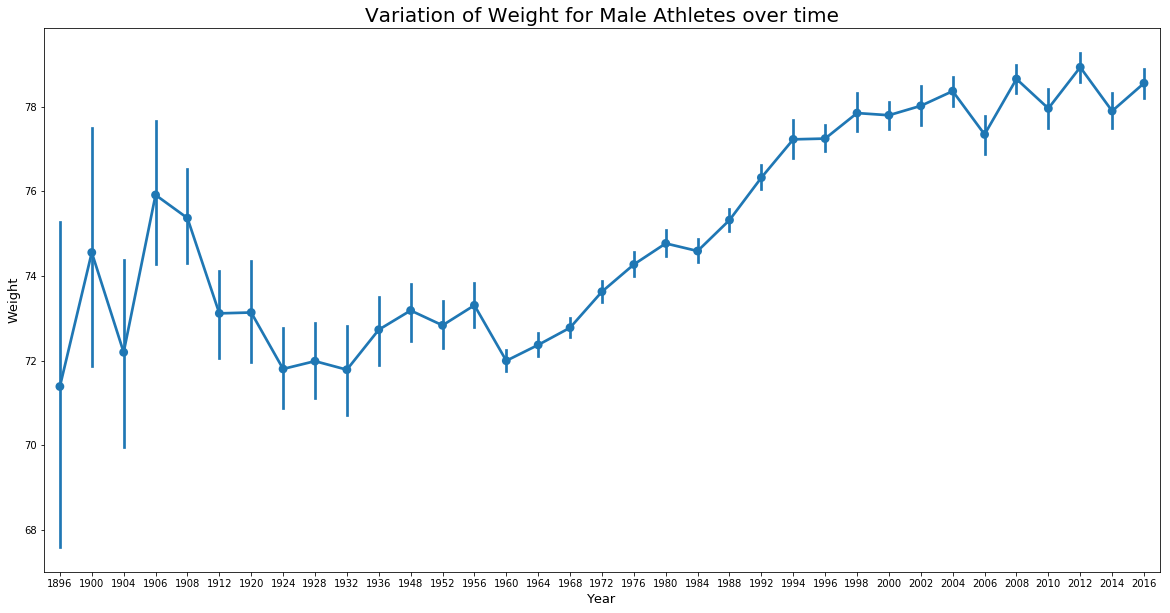

In [134]:
plt.figure(figsize=(20,10))
sns.pointplot('Year','Weight',data=men_weight_df)
plt.xlabel('Year',fontsize=13)
plt.ylabel('Weight',fontsize=13)
plt.title('Variation of Weight for Male Athletes over time',fontsize=20);

/Volumes/mac_file/安装软件/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


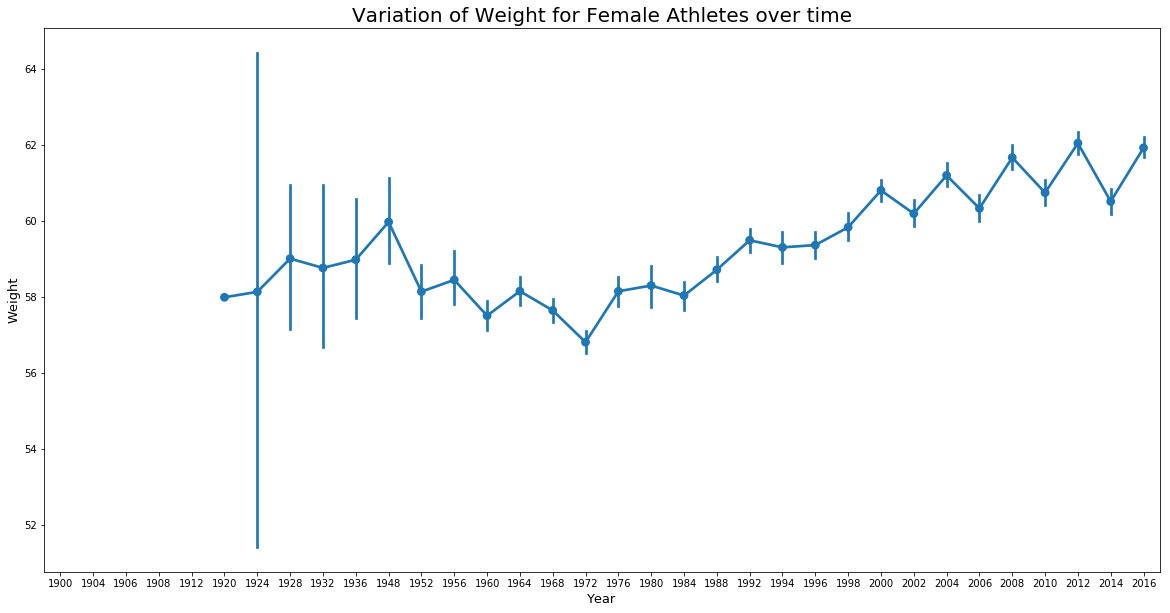

In [135]:
plt.figure(figsize=(20,10))
sns.pointplot('Year','Weight',data=women_weight_df)
plt.xlabel('Year',fontsize=13)
plt.ylabel('Weight',fontsize=13)
plt.title('Variation of Weight for Female Athletes over time',fontsize=20);

## 问题六：历届奥运会奖牌榜总排名

我们要单独创造出一列，用于表示是否得奖，我们把得奖标记为1，未得奖标记为0。

In [136]:
olympic_df['Medal_Won'] = np.where(olympic_df['Medal'] == "DNW",0,1)

In [137]:
olympic_df.head()

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Medal_Won
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,0
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China,0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,DNW,Denmark,0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,1
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,DNW,Netherlands,0


数据当中的每一行表示的是某一运动员在某一届奥运会上的获奖情况，但是团体赛的每一名队员都获得了金牌，但是只能算一枚。因此，我们要把个人赛和团体赛分开，那么我们怎样来甄别团体赛呢？

我们按运动项目和年份聚合，如果获奖运动项目（Event）的获奖牌数大于1，那么则证明该项目是团体赛。

In [143]:
team_single_df = pd.pivot_table(olympic_df,
                               index=['Country','Year','Event'],
                               columns='Medal',
                               values='Medal_Won',
                               aggfunc='sum',
                               fill_value=0).drop('DNW',axis=1).reset_index()
team_single_df.head()

Medal,Country,Year,Event,Bronze,Gold,Silver
0,Afghanistan,1936,Athletics Men's 100 metres,0,0,0
1,Afghanistan,1936,Athletics Men's Long Jump,0,0,0
2,Afghanistan,1936,Athletics Men's Shot Put,0,0,0
3,Afghanistan,1936,Hockey Men's Hockey,0,0,0
4,Afghanistan,1948,Football Men's Football,0,0,0


In [144]:
team_single = team_single_df.query('Gold > 1')['Event'].unique()

In [145]:
team_single

array(["Polo Men's Polo", "Rowing Men's Double Sculls",
       "Basketball Men's Basketball", "Football Men's Football",
       "Cycling Men's Madison", "Hockey Men's Hockey",
       'Sailing Mixed Multihull', "Rugby Men's Rugby",
       "Swimming Men's 4 x 200 metres Freestyle Relay",
       "Cycling Men's Tandem Sprint, 2,000 metres",
       "Athletics Women's 4 x 100 metres Relay",
       "Swimming Women's 4 x 100 metres Freestyle Relay",
       "Equestrianism Men's Three-Day Event, Team",
       'Sailing Mixed 5.5 metres', 'Sailing Mixed Three Person Keelboat',
       'Sailing Mixed Two Person Keelboat',
       "Swimming Men's 4 x 100 metres Medley Relay",
       "Cycling Men's Team Pursuit, 4,000 metres",
       "Hockey Women's Hockey",
       'Equestrianism Mixed Three-Day Event, Team',
       "Rowing Men's Coxless Fours", "Rowing Women's Coxless Pairs",
       "Tennis Men's Doubles",
       "Beach Volleyball Women's Beach Volleyball",
       "Sailing Men's Two Person Dinghy",
  

老实讲我也不知道原作者是怎么从上面这么多运动项目中找出来四个非团体醒目：

1. Gymnastics Women's Balance Beam
2. Gymnastics Men's Horizontal Bar
3. Swimming Women's 100 metres Freestyle
4. Swimming Men's 50 metres Freestyle

然后我们将这些项目从团体项目中删除

In [146]:
remove_sports = ["Gymnastics Women's Balance Beam", "Gymnastics Men's Horizontal Bar", 
                 "Swimming Women's 100 metres Freestyle", "Swimming Men's 50 metres Freestyle"]

team_single = list(set(team_single) - set(remove_sports))

In [148]:
team_event_mask = olympic_df['Event'].map(lambda x: x in team_single)

In [150]:
single_event_mask = [not i for i in team_event_mask]

In [151]:
medal_mask = olympic_df['Medal_Won'] == 1

#创建团体项目并获奖的列，是团体项目的标记为1，否则为0
olympic_df['Team_Event'] = np.where(team_event_mask & medal_mask,1,0)

#创建担任项目列并获奖，是担任项目的标记为1，否则为0
olympic_df['Single_Event'] = np.where(single_event_mask & medal_mask,1,0)

#创建一个获奖列
olympic_df['Event_Category'] = olympic_df['Team_Event'] + olympic_df['Single_Event']

olympic_df.head()

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Medal_Won,Team_Event,Single_Event,Event_Category
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,0,0,0,0
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China,0,0,0,0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,DNW,Denmark,0,0,0,0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,1,1,0,1
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,DNW,Netherlands,0,0,0,0


下面我们开始计算真实的获奖数：

In [161]:
country_medal_df = olympic_df.query('Event_Category == 1')['Country'].value_counts().reset_index(name='Medal')

country_medal_df.head()

,index,Medal
0,USA,5637
1,Russia,3947
2,Germany,3756
3,UK,2067
4,France,1767


In [163]:
medal_tally_agnostic = olympic_df.groupby(['Year', 'Country', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].agg('sum').reset_index()

medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']

medal_tally_agnostic.head()

,Year,Country,Event,Medal,Medal_Won,Event_Category,Medal_Won_Corrected
0,1896,Australia,"Athletics Men's 1,500 metres",Gold,1,1,1.0
1,1896,Australia,Athletics Men's 800 metres,Gold,1,1,1.0
2,1896,Australia,Athletics Men's Marathon,DNW,0,0,NaN
3,1896,Australia,Tennis Men's Doubles,Bronze,1,1,1.0
4,1896,Australia,Tennis Men's Singles,DNW,0,0,NaN


In [168]:
medal_tally = medal_tally_agnostic.groupby(['Year','Country'])['Medal_Won_Corrected'].agg('sum').reset_index()

medal_tally.query('Year == 2008').sort_values('Medal_Won_Corrected')

,Year,Country,Medal_Won_Corrected
2597,2008,Libya,0.0
2586,2008,Jordan,0.0
2637,2008,Peru,0.0
2638,2008,Philippines,0.0
2583,2008,Ivory Coast,0.0
2641,2008,Puerto Rico,0.0
2642,2008,Qatar,0.0
2643,2008,Republic of Congo,0.0
2579,2008,Iraq,0.0
2646,2008,Rwanda,0.0


In [166]:
medal_tally_pivot = pd.pivot_table(medal_tally,
                     index = 'Country',
                     columns = 'Year',
                     values = 'Medal_Won_Corrected',
                     aggfunc = 'sum',
                     margins = True).sort_values('All', ascending = False)[1:5]

# print total medals won in the given period
medal_tally_pivot.loc[:,'All']

Country
USA        2823.0
Russia     1916.0
Germany    1766.0
UK          919.0
Name: All, dtype: float64

**我们可以和第三个问题比较发现：在没有剔除团队获奖项目之前，我们统计的奖牌榜存在很大问题，仅美国获得金牌就有5000之多，而区别团体之后，美国总奖牌不过2823，和实际接近（仍多于实际获奖数，说明我们在筛选数据是仍在还存在问题）。我们下面来观察这前四名历届奥运会的获奖情况。**

In [169]:
medal_tally.head()

,Year,Country,Medal_Won_Corrected
0,1896,Australia,3.0
1,1896,Austria,5.0
2,1896,Denmark,6.0
3,1896,France,11.0
4,1896,Germany,14.0


In [177]:
top_four_country = ['USA','Russia','Germany','UK']
medal_top_four = pd.pivot_table(medal_tally,
                               index='Year',
                               columns='Country',
                               values='Medal_Won_Corrected',
                               aggfunc='sum')[top_four_country]

In [179]:
medal_top_four.reset_index(inplace=True)

In [180]:
medal_top_four.head()

Country,index,Year,USA,Russia,Germany,UK
0,0,1896,19.0,NaN,14.0,9.0
1,1,1900,54.0,0.0,8.0,42.0
2,2,1904,230.0,NaN,16.0,2.0
3,3,1906,23.0,NaN,14.0,25.0
4,4,1908,46.0,3.0,13.0,143.0


In [191]:
row_mask_2 = medal_tally_agnostic['Country'].map(lambda x: x in top_four_country)
medal_tally_specific = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                     index = ['Country'],
                                     columns = 'Medal',
                                     values = 'Medal_Won_Corrected',
                                     aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1)

In [192]:
medal_tally_specific.head()

Medal,Bronze,Gold,Silver
Country,,,
Germany,596,578,592
Russia,589,727,600
UK,310,289,320
USA,791,1131,901


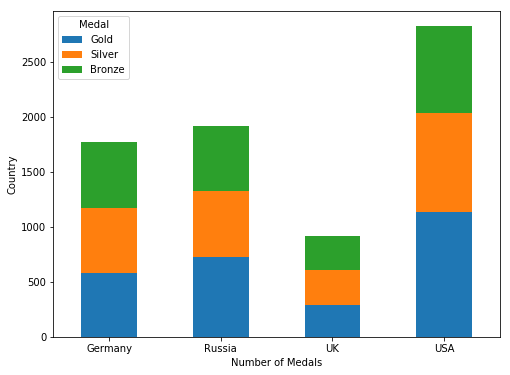

In [197]:
medal_tally_specific = medal_tally_specific[['Gold', 'Silver', 'Bronze']]

medal_tally_specific.plot(kind = 'bar', stacked = True, figsize = (8,6), rot = 0)

plt.xlabel('Number of Medals')
plt.ylabel('Country');

<a id="conclusions"></a>
## 结论：
1. 一共有52个城市举办过奥运会，其中不免有些城市多次举办。因斯布鲁克举办过1964年冬季奥运会和1976年冬季奥运会；纽约普莱西德湖举办过1932年冬季奥运会和1984年冬季奥运会；洛杉矶举办过1932年夏季奥运会和1984年夏季奥运会；巴黎举办过1900年夏季奥运会和1924年夏季奥运会；瑞士恩加丁山谷圣莫里茨举办过1928年冬季奥运会和1948年冬季奥运会；斯德哥尔摩举办过1912年夏季奥运会和1956年夏季奥运会；伦敦举办过1908年夏季奥运会，1948年夏季奥运会，2012年夏季奥运会；雅典举办过1896年夏季奥运会，1906年夏季奥运会，2004年夏季奥运会。
2. 奥运会曾经有过艺术类比赛，其中不乏一些年迈的老人。
3. 无论是身高还是体重，远动员的身体素质呈现上升趋势。
4. 运动员的黄金年龄是25岁左右，这个年龄在身体素质还是心智成长上，都是一个人的黄金时间。
5. 从历届奥运会奖牌得数来看，美国遥遥领先。

<a id="limitation"></a>
## 限制：
1. 我们在筛选数据的时候不免有些考虑不周，从实际情况来看，有些数据与真实数据有一定的出入。
2. 此数据我们还可以探索更多的问题，限于篇幅，往后会再找时间来重新了解列届奥运会的情况。